In [1]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import os
import numpy as np
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [2]:
top_down_path = os.getcwd()
os.chdir("../Data")
data_path = os.getcwd()
os.chdir(top_down_path)

# Read data

In [3]:
# Read preprocessed
df = pd.read_csv(os.path.join(data_path, "preprocessed.csv"), index_col=0)
df.index = pd.to_datetime(df.index)

In [4]:
df[['rlm', 'slp']].mean() * 365 #/ df[['slp', 'rlm']].sum().sum()

rlm    586.975086
slp    408.364157
dtype: float64

In [5]:
df.head().transpose()

,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05
slp,2.302289,2.362777,2.284347,2.203892,2.509253
rlm,1.673442,2.056043,2.030095,2.108759,2.358004
industry,1.133007,1.31413,1.344038,1.399122,1.437929
gas_to_electricity_public,0.217912,0.367832,0.303461,0.311361,0.510752
electricity_from_gas,0.139161,0.234902,0.193794,0.198839,0.326173
gas_price [€/MWh],NaN,NaN,NaN,NaN,NaN
producing_sector,91.1,91.1,91.1,91.1,91.1
manufacturing_sector,94.1,94.1,94.1,94.1,94.1
hospitality_sector,82.6,82.6,82.6,82.6,82.6
retail_sector,96.1,96.1,96.1,96.1,96.1


# Prepare regression data

In [6]:
dfx = df.copy()
dfx = dfx.rename(columns={
    'aggregated': 'w2h',
    'gas_to_electricity_public': 'power',
    'producing_sector': 'prod',
    'manufacturing_sector': 'manu',
    'retail_sector': 'retail',
    'hospitality_sector': 'hosp',
    'gas_price [€/MWh]': 'prices',
    'temperature': 'temp',
    'temperature_inertia': 'temp_inertia',
})

dfx['log_slp'] = np.log(dfx['slp'])
dfx['log_rlm'] = np.log(dfx['rlm'])
dfx['log_power'] = np.log(dfx['power'])
dfx['log_industry'] = np.log(dfx['industry'])
dfx['power2'] = dfx['power'].apply(lambda x: x**2)

dfx = dfx[
    (dfx.holiday==0) & 
    (dfx.christmas_period==0) & 
    (dfx.bridgeday==0)
]

# Cut December 22-23
dfx = dfx[((dfx.index.month!=12)|(dfx.index.day<22))]

# Cut corona
# covid_beginning = "2020-02-01" --> lockdown started on 13 March 2020
#dfx = dfx[(dfx.index < '2020-03-01')|(dfx.index >= '2021-05-01')]
# invasion_date = "2022-02-24"


In [7]:
def model(dependent_variable, control_list):
    
    m = f'{dependent_variable} ~ 1 + time + C(month) + C(weekday) + ' + ' + '.join(control_list)
    print(m)
    return smf.ols(m, dfx[(dfx.index >= fitting_start) & (dfx.index <= fitting_end)]).fit(cov_type='HAC', cov_kwds={'maxlags':6})

In [8]:
def all_models(dummy_list, consumer='rlm', further_controls=False, econ=False):
    
    results = {}
    
    names = ['naive', 'temp',]
    if econ:
        names += ['temp+econ']
    if consumer == 'rlm':
        names += ['temp+econ']
    if consumer == 'power':
        names = ['naive']
    
    for name in names:
    
        control_list = [d for d in dummy_list]        
        if 'temp' in name:
            control_list += ['w2h','time*w2h']
        if 'econ' in name:
            control_list += ['manu'] if (consumer=='rlm' or consumer=='industry') else ['hosp','retail']
        if 'naive' in name:
            control_list = control_list
        results[name] = model(f'{"log_" if log else ""}{consumer}', control_list)

    return results

In [9]:
def extract_results(dummy_list, results):
    
    extracted_results = pd.concat(
        [results.params, results.bse], keys=['coef', 'se'], axis=1
    )
    
    extracted_results = extracted_results*100 if log else extracted_results
    extracted_results = extracted_results.loc[[d + '[T.True]' for d in dummy_list]]
    extracted_results.index = dummy_list
    extracted_results['low'] = extracted_results['coef'] - 2 * extracted_results['se']
    extracted_results['high'] = extracted_results['coef'] + 2 * extracted_results['se']
    
    return extracted_results

# One crisis dummy

In [10]:
title_conversion = {
        'slp':'Small consumers',
        'rlm':'Large consumers',
        'industry':'Industrial consumers',  
        'power':'Power sector'  
}

In [11]:
def plot_waterfall(ax, results, consumer='rlm', ylabel=''):

    colors = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green', 'tab:red']
    
    for i, (name, res) in enumerate(results.items()):
        
        # first bar
        if i==0:
            ax.bar(i, res['coef'], alpha=0.5, color=colors[i])
            ax.plot([i,i], [res['low'], res['high']], color=colors[i])
        
        # waterfall
        if i > 0:
            ax.bar(i, res['coef'] - previous_coef, bottom=previous_coef, alpha=0.5, color=colors[i])    
            ax.plot([i-1.4,i+0.4], [previous_coef, previous_coef], color='black', linewidth=0.7, linestyle='--')
            ax.plot([i-0.4,i+1.4], [res['coef'], res['coef']], color='black', linewidth=0.7, linestyle='--')
            
        previous_coef = res['coef']
    
    # last bar
    if consumer != "power":
        i += 1
        ax.bar(i, res['coef'], alpha=0.5, color=colors[-1])
        ax.plot([i,i], [res['low'], res['high']], color=colors[-1])

    ax.grid(axis='y')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_ylabel(ylabel)
    ax.set_title(title_conversion[consumer])    
    if log:
        ax.set_ylim(-21, 7)
        
    labels = ['Overall\nchange', 'Temperature']
    if 'temp+econ' in results.keys():
        labels += ['Economic\nactivity']
    if consumer=='rlm': 
        labels += ['Power\nsector']
    if consumer=='power': 
        labels = ['Overall\nchange']
    ax.set_xticks(range(len(results)) if consumer == "power" else range(len(results)+1))
    ax.set_xticklabels(labels if consumer == "power" else (labels + ['Crisis\nresponse']))

In [12]:
def one_dummy(further_controls=False, econ=False):
    
    dummy_list=['crisis']
    dfx['crisis'] = dfx.index.map(lambda x: x >= crisis_start)

    results = {
        consumer: all_models(dummy_list, consumer, further_controls=further_controls, econ=econ) 
        for consumer in ['slp', 'industry', 'power']

    }
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4.5), sharey='row', gridspec_kw={'width_ratios': [1,1,0.4]})

    res = {m: extract_results(dummy_list, value) for m, value in results['slp'].items()}
    ax1 = plot_waterfall(ax1, res, 'slp', 'Estimated change in demand ' + ('(%)' if log else '(TWh/d)'))

    res = {m: extract_results(dummy_list, value) for m, value in results['industry'].items()}
    ax2 = plot_waterfall(ax2, res, 'industry')
    
    res = {m: extract_results(dummy_list, value) for m, value in results['power'].items()}
    ax3 = plot_waterfall(ax3, res, 'power')

    plt.tight_layout()
    
    return results

## Main Specification

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h
slp ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h
industry ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h + manu
power ~ 1 + time + C(month) + C(weekday) + crisis


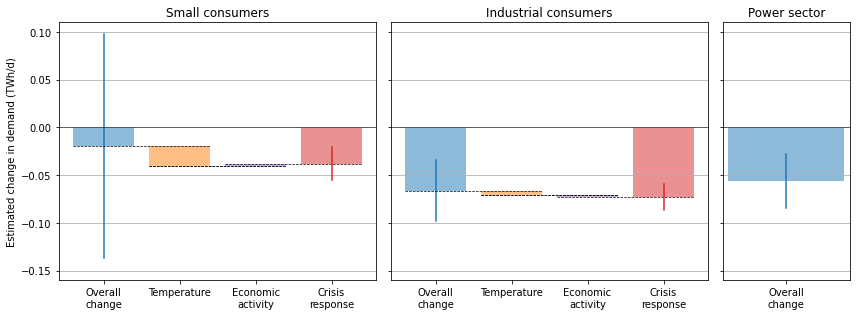

In [13]:
log=False
fitting_start = "2017-01-01"
fitting_end = "2022-05-01"
crisis_start = "2021-08-01"
results = one_dummy(econ=True)
plt.ylim(-.16, .11)
plt.savefig(f'one_dummy.png', dpi=300)

In [14]:
results['industry']['temp+econ'].summary()
#results['power']['naive'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               industry   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     936.8
Date:                Fri, 22 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:03:28   Log-Likelihood:                 2986.4
No. Observations:                1788   AIC:                            -5927.
Df Residuals:                    1765   BIC:                            -5801.
Df Model:                          22                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.7325      0.037     19.944      0.000       0.660       0.804
C(month)[T.2]              -0.0233      0.009     -2.642      0.008      -0.041      -0.006
C(month)[T.3]              -0.0853      0.011     -8.033      0.000      -0.106      -0.064
C(month)[T.4]              -0.1271      0.010    -13.248      0.000      -0.146      -0.108
C(month)[T.5]              -0.1230      0.011    -11.669      0.000      -0.144      -0.102
C(month)[T.6]              -0.1216      0.012     -9.825      0.000      -0.146      -0.097
C(month)[T.7]              -0.1342      0.013    -10.418      0.000      -0.159      -0.109
C(month)[T.8]              -0.1309      0.014     -9.069      0.000      -0.159      -0.103
C(month)[T.9]              -0.1041      0.012     -8.522      0.000      -0.128      -0.080
C(month)[T.10]             -0.0598      0.011     -5.531      0.000      -0.081      -0.039
C(month)[T.11]             -0.0389      0.010     -4.003      0.000      -0.058      -0.020
C(month)[T.12]             -0.0195      0.009     -2.155      0.031      -0.037      -0.002
C(weekday)[T.Monday]        0.0459      0.004     11.495      0.000       0.038       0.054
C(weekday)[T.Saturday]     -0.1040      0.003    -34.396      0.000      -0.110      -0.098
C(weekday)[T.Sunday]       -0.0767      0.004    -21.603      0.000      -0.084      -0.070
C(weekday)[T.Thursday]      0.0373      0.003     12.424      0.000       0.031       0.043
C(weekday)[T.Tuesday]       0.0381      0.004      9.459      0.000       0.030       0.046
C(weekday)[T.Wednesday]     0.0409      0.004     11.367      0.000       0.034       0.048
crisis[T.True]             -0.0725      0.007    -10.695      0.000      -0.086      -0.059
time                     2.172e-05   6.24e-06      3.480      0.001    9.49e-06    3.39e-05
w2h                         0.2357      0.007     34.245      0.000       0.222       0.249
time:w2h                 1.086e-06   4.87e-06      0.223      0.824   -8.45e-06    1.06e-05
manu                        0.0009      0.000      2.748      0.006       0.000       0.002
==============================================================================
Omnibus:                       16.372   Durbin-Watson:                   0.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.751
Skew:                           0.095   Prob(JB):                     1.15e-05
Kurtosis:                       3.519   Cond. No.                     3.80e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 6 lags and without small sample correction
[2] The condition number is large, 3.8e+04. This might indicate that there are
stron

In [15]:
# year-on-year
for con, mod  in [('industry','temp+econ'),('slp','temp+econ'),('power','naive')]:
    
    crisis_coefficient = -results[con][mod].params["crisis[T.True]"]
    ref = dfx[(dfx.index >= '2020-08-01') & (dfx.index < '2021-05-01')][con].mean()  #, (338+58)/(338+141+58))
    print(
          title_conversion[con] + ": " + str(round(crisis_coefficient,4)) + " TWh/d " + "\n" +"which is " + str(round(100*crisis_coefficient/ ref)) +" % of "+ str(round(ref,4)) + " TWh/d avg. demand during months 8-3 before crisis"+ "\n" 
         )

Industrial consumers: 0.0725 TWh/d 
which is 7 % of 1.0944 TWh/d avg. demand during months 8-3 before crisis

Small consumers: 0.0381 TWh/d 
which is 3 % of 1.386 TWh/d avg. demand during months 8-3 before crisis

Power sector: 0.0559 TWh/d 
which is 14 % of 0.3968 TWh/d avg. demand during months 8-3 before crisis



Check correlation between independent variables

In [16]:
print(np.corrcoef(dfx['commercial'], dfx['residential'])) #very strong correlation between commercial and residential

[[1.         0.99673407]
 [0.99673407 1.        ]]


In [17]:
print(np.corrcoef(dfx['manu'], dfx['prod'])) #very strong correlation between manu and prod

[[1.         0.97392426]
 [0.97392426 1.        ]]


In [18]:
dfx['crisis_int'] = dfx['crisis'].astype(int)
print(np.corrcoef(dfx['time'], dfx['crisis_int'])) #moderate correlation between time and crisis

[[1.        0.5999517]
 [0.5999517 1.       ]]


In [19]:
dfx['time_w2h'] = dfx['time']*dfx['w2h']

print(np.corrcoef(dfx['time'], dfx['time_w2h'])) #moderate correlation between time and crisis

[[1.         0.66379651]
 [0.66379651 1.        ]]


# Quarterly dummies (not currently used)

In [20]:
mode = 'quarterly'
crisis_start = "2021-09-01"
dummy_list = []
for date in pd.date_range(crisis_start, '2022-04', freq='3m'):
    dummy_name = f'd{date.year}_{date.quarter}'
    dfx[dummy_name] = dfx.index.map( 
        lambda x: (x.year==date.year) & (x.quarter==date.quarter)
    ).values
    dummy_list.append(dummy_name)

# Monthly dummies

In [21]:
mode = 'monthly'
crisis_start = "2021-05-01"
dummy_list = []
for date in pd.date_range(crisis_start, fitting_end, freq='1m'):
    dummy_name = f'd{date.year}_{date.month}'
    dfx[dummy_name] = dfx.index.map(   
        lambda x: (x.year==date.year) & (x.month==date.month)
    ).values
    dummy_list.append(dummy_name)

In [22]:
def plot_monthly(ax, results, consumer='industry', ylabel='Crisis response (TWh/d)', names=None):

    colors = {
        'naive': 'tab:blue',
        'temp+econ': ('tab:orange' if consumer=='industry' else 'tab:red'),
        'power': 'tab:green'
    }
    extracted_results = {m: extract_results(dummy_list, value) for m, value in results[consumer].items()}
    
    if names==None:
        names = extracted_results.keys()
    
    for i, name in enumerate(names):
        
        res = extracted_results[name]
        
        idx = [j-0.15*(len(names)-1)+0.6/len(names)*i for j in range(len(res))]
        ax.bar(idx, res['coef'], width=0.6/len(names),alpha=0.5, label=name, color=colors[name])
        for j, d in enumerate(dummy_list):
            ax.plot([idx[j], idx[j]], [res.loc[d, 'low'], res.loc[d, 'high']], 
                     color=colors[name])
    ax.grid(axis='y')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_ylabel(ylabel)
    ax.set_ylim(-0.21, 0.1)
    title_conversion = {
        'slp':'Small consumers',
        'rlm':'Large consumers',
        'industry':'Industrial consumers',
        'power': "Power sector"
    }
    ax.set_title(title_conversion[consumer])
   
    ax.set_xticks(
        range(len(res)), 
    #    [f'{date.month_name()[:3]}'+(f'\n{date.year}' if ((date.month==1) | (i==0)) else '')
    #     for i, date in enumerate(pd.date_range(crisis_start, '2022-05', freq='1m'))]
    )
    ax.set_xticklabels(
        [f'{date.month_name()[:3]}'+(f'\n{date.year}' if ((date.month==1) | (i==0)) else '')
         for i, date in enumerate(pd.date_range(crisis_start, fitting_end, freq='1m'))]
    )
    
    ax.axvline(7.5, color='black', linewidth=0.5)

In [23]:
log=False
fitting_start = "2017-01-01"
fitting_end = "2022-05-01"
results = {consumer: all_models(dummy_list, consumer, econ=True) for consumer in ['slp', 'industry', 'power']}

slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4
slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + w2h + time*w2h
slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + w2h + time*w2h + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4
industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + w2h + time*w2h
industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_

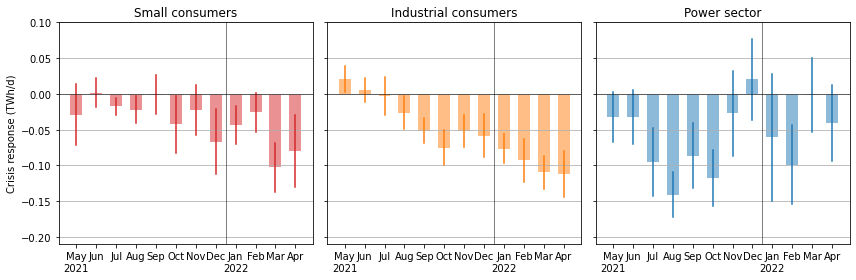

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4), sharey='row', gridspec_kw={'width_ratios': [1,1,1]})

plot_monthly(ax1, results, 'slp', names=['temp+econ'])
#ax1.text(10.5, 0.02, 'Invasion\nof Ukraine', horizontalalignment='center')

plot_monthly(ax2, results, names=['temp+econ'], ylabel='')
#ax2.text(4.5, 0.02, 'TTF prices\nall-time-high', horizontalalignment='center')

plot_monthly(ax3, results, "power", names=['naive'], ylabel='')
#ax2.text(4.5, 0.02, 'TTF prices\nall-time-high', horizontalalignment='center')

plt.tight_layout()
plt.savefig('months.png')

In [25]:
results['industry']['temp+econ'].summary()
#results['power']['naive'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               industry   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     930.1
Date:                Fri, 22 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:03:30   Log-Likelihood:                 3024.6
No. Observations:                1788   AIC:                            -5981.
Df Residuals:                    1754   BIC:                            -5795.
Df Model:                          33                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.7326      0.040     18.419      0.000       0.655       0.811
C(month)[T.2]              -0.0209      0.010     -2.115      0.034      -0.040      -0.002
C(month)[T.3]              -0.0815      0.012     -6.880      0.000      -0.105      -0.058
C(month)[T.4]              -0.1217      0.010    -11.968      0.000      -0.142      -0.102
C(month)[T.5]              -0.1290      0.011    -11.520      0.000      -0.151      -0.107
C(month)[T.6]              -0.1246      0.013     -9.876      0.000      -0.149      -0.100
C(month)[T.7]              -0.1354      0.013    -10.271      0.000      -0.161      -0.110
C(month)[T.8]              -0.1412      0.015     -9.279      0.000      -0.171      -0.111
C(month)[T.9]              -0.1098      0.012     -8.799      0.000      -0.134      -0.085
C(month)[T.10]             -0.0613      0.012     -5.140      0.000      -0.085      -0.038
C(month)[T.11]             -0.0453      0.011     -4.151      0.000      -0.067      -0.024
C(month)[T.12]             -0.0237      0.011     -2.210      0.027      -0.045      -0.003
C(weekday)[T.Monday]        0.0456      0.004     11.464      0.000       0.038       0.053
C(weekday)[T.Saturday]     -0.1039      0.003    -34.316      0.000      -0.110      -0.098
C(weekday)[T.Sunday]       -0.0770      0.004    -21.850      0.000      -0.084      -0.070
C(weekday)[T.Thursday]      0.0375      0.003     12.667      0.000       0.032       0.043
C(weekday)[T.Tuesday]       0.0379      0.004      9.471      0.000       0.030       0.046
C(weekday)[T.Wednesday]     0.0410      0.004     11.501      0.000       0.034       0.048
d2021_5[T.True]             0.0211      0.009      2.387      0.017       0.004       0.038
d2021_6[T.True]             0.0055      0.008      0.663      0.507      -0.011       0.022
d2021_7[T.True]            -0.0025      0.013     -0.189      0.850      -0.028       0.023
d2021_8[T.True]            -0.0262      0.012     -2.273      0.023      -0.049      -0.004
d2021_9[T.True]            -0.0511      0.009     -5.954      0.000      -0.068      -0.034
d2021_10[T.True]           -0.0749      0.012     -6.199      0.000      -0.099      -0.051
d2021_11[T.True]           -0.0523      0.011     -4.626      0.000      -0.074      -0.030
d2021_12[T.True]           -0.0582      0.015     -3.850      0.000      -0.088      -0.029
d2022_1[T.True]            -0.0763      0.010     -7.341      0.000      -0.097      -0.056
d2022_2[T.True]            -0.0928      0.015     -6.277      0.000      -0.122      -0.064
d2022_3[T.True]            -0.1094      0.012     -9.425      0.000      -0.132      -0.087
d2022_4[T.True]            -0.1120      0.016     -6.868      0.000      -0.144      -0.080
time                     1.574e-05   8.27e-06  

In [26]:
# % changes compared to previous months

def monthlycoefficients(dfx=dfx, results=results):
    res = {}

    for con, mod  in [('industry','temp+econ'),('slp','temp+econ')]:
        for year in [2021,2022]:
            for month in range(1,12+1):
                try:

                    coeff_abs = results[con][mod].params[f'd{year}_{month}[T.True]']
                    
                    ref = dfx[(dfx.index.year < year) & (dfx.index.month.isin([month]))][con].mean()
                    coeff = round(coeff_abs/ref, 2)*100

                    res[(con, year, month)] = coeff
                    
                    
                except KeyError:
                    pass                
    
    ds = pd.Series(res.values(), index=res.keys())
    ds.index.names = ['type','year','month']
    
    return ds.unstack('type')

monthlycoefficients()

type        industry  slp
year month               
2021 5           2.0 -5.0
     6           1.0  1.0
     7          -0.0 -7.0
     8          -4.0 -9.0
     9          -6.0 -0.0
     10         -8.0 -5.0
     11         -5.0 -1.0
     12         -5.0 -3.0
2022 1          -6.0 -2.0
     2          -7.0 -1.0
     3         -10.0 -6.0
     4         -12.0 -8.0

## Residuals

slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4
slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + w2h + time*w2h
slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + w2h + time*w2h + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4
industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + w2h + time*w2h
industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_

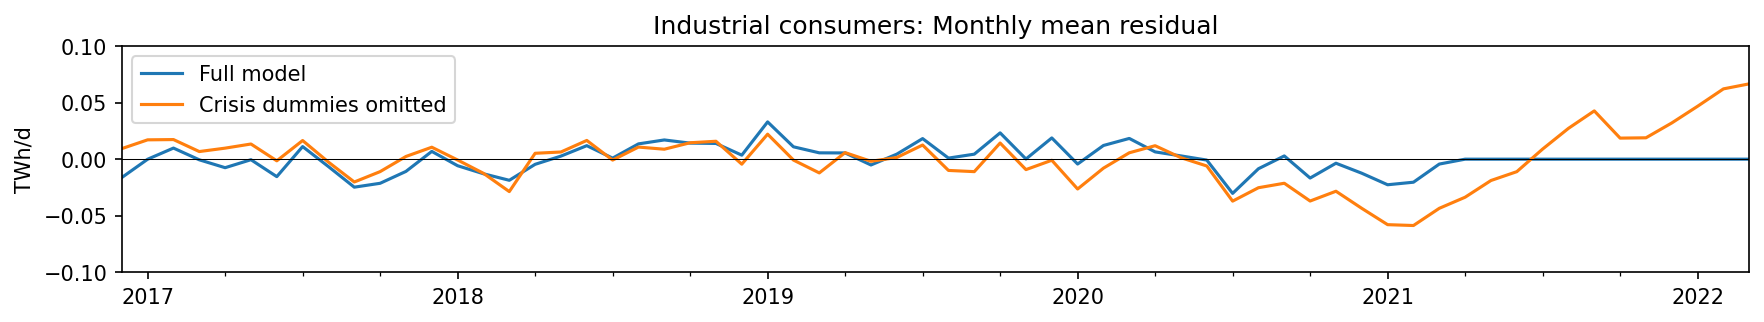

In [27]:
log=False
fitting_start = "2017-01-01"
fitting_end = "2022-05-01"
results = {consumer: all_models(dummy_list, consumer, econ=True) for consumer in ['slp', 'industry', 'power']}

resid_full = results['industry']['temp+econ'].fittedvalues - dfx['industry'] 
resid_fullm = resid_full.resample('1m', label='left').mean()

m_industry = f'industry ~ 1 + time + C(month) + C(weekday) + w2h + time*w2h + manu' # industry: model without crisis dummy 
resid_nodummy = smf.ols(m_industry, dfx[(dfx.index >= fitting_start) & (dfx.index <= fitting_end)]).fit(cov_type='HAC', cov_kwds={'maxlags':6}).fittedvalues - dfx['industry']

resid_nodummym = resid_nodummy.resample('1m', label='left').mean()

plt.figure(figsize=(14, 2), dpi=150)
resid_fullm.plot(label='Full model')
resid_nodummym.plot(label='Crisis dummies omitted')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend(loc='upper left')
plt.title('Industrial consumers: Monthly mean residual')
plt.ylabel('TWh/d')
plt.ylim(-0.1, 0.1)
plt.savefig(f'resid_industry.png', dpi=300)

slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4
slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + w2h + time*w2h
slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + w2h + time*w2h + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4
industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + w2h + time*w2h
industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_

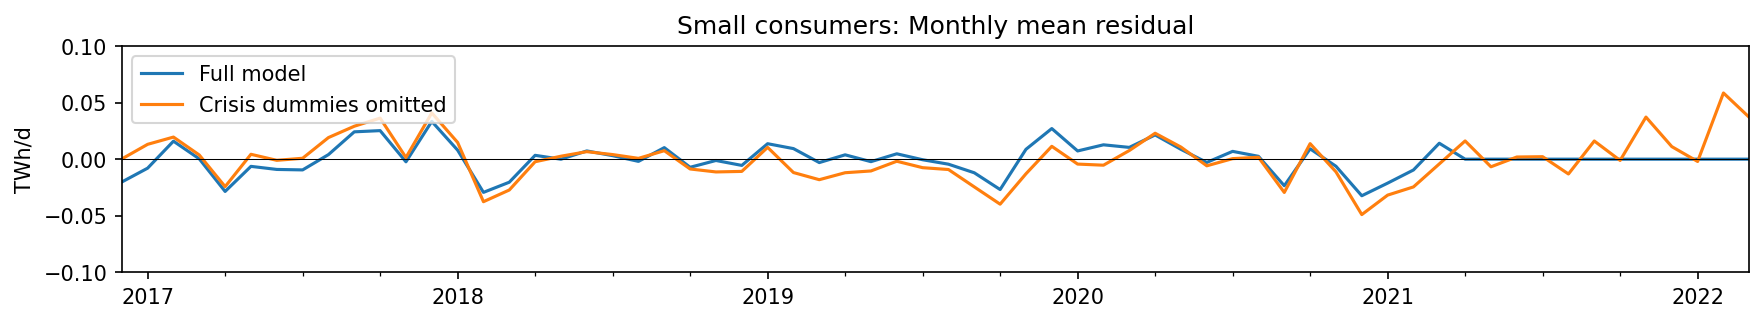

In [28]:
log=False
fitting_start = "2017-01-01"
fitting_end = "2022-05-01"
results = {consumer: all_models(dummy_list, consumer, econ=True) for consumer in ['slp', 'industry', 'power']}

resid_full = results['slp']['temp+econ'].fittedvalues - dfx['slp'] 
resid_fullm = resid_full.resample('1m', label='left').mean()

fitting_start = "2017-01-01"
m_slp = f'slp ~ 1 + time + C(month) + C(weekday) + w2h + time*w2h + hosp + retail' # small consumers: model without crisis dummy 
resid_nodummy = smf.ols(m_slp, dfx[(dfx.index >= fitting_start) & (dfx.index <= fitting_end)]).fit(cov_type='HAC', cov_kwds={'maxlags':6}).fittedvalues - dfx['slp']
resid_nodummym = resid_nodummy.resample('1m', label='left').mean()

plt.figure(figsize=(14, 2), dpi=150)
resid_fullm.plot(label='Full model')
resid_nodummym.plot(label='Crisis dummies omitted')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend(loc='upper left')
plt.title('Small consumers: Monthly mean residual')
plt.ylabel('TWh/d')
plt.ylim(-0.1, 0.1)
plt.savefig(f'resid_small.png', dpi=300)

slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4
slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + w2h + time*w2h
slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + w2h + time*w2h + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4
industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + w2h + time*w2h
industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_

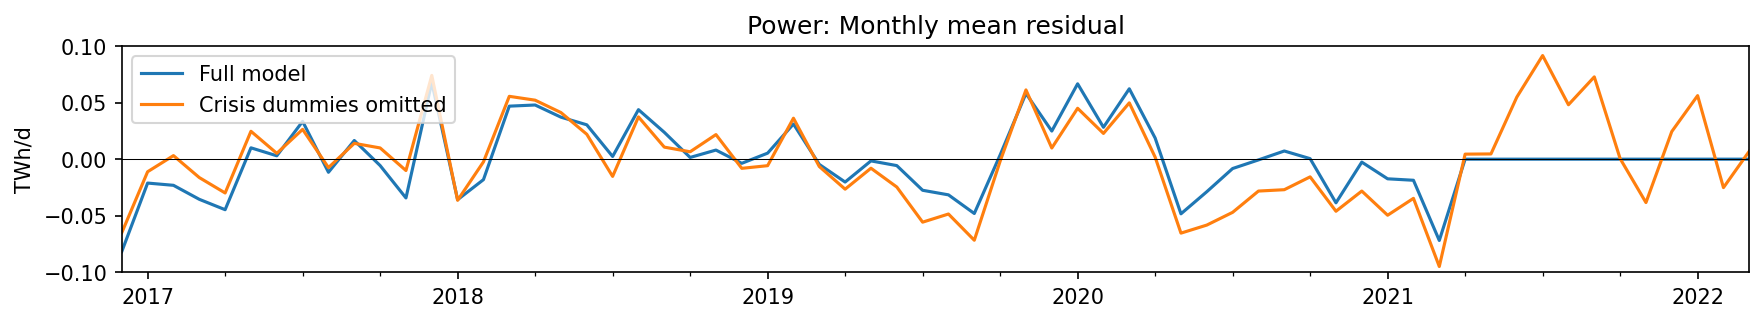

In [29]:
log=False
fitting_start = "2017-01-01"
fitting_end = "2022-05-01"
results = {consumer: all_models(dummy_list, consumer, econ=True) for consumer in ['slp', 'industry', 'power']}

resid_full = results['power']['naive'].fittedvalues - dfx['power'] 
resid_fullm = resid_full.resample('1m', label='left').mean()

fitting_start = "2017-01-01"
m_power = f'power ~ 1 + time + C(month) + C(weekday)' # power: model without crisis dummy 
resid_nodummy = smf.ols(m_power, dfx[(dfx.index >= fitting_start) & (dfx.index <= fitting_end)]).fit(cov_type='HAC', cov_kwds={'maxlags':6}).fittedvalues - dfx['power']
resid_nodummym = resid_nodummy.resample('1m', label='left').mean()

plt.figure(figsize=(14, 2), dpi=150)
resid_fullm.plot(label='Full model')
resid_nodummym.plot(label='Crisis dummies omitted')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend(loc='upper left')
plt.title('Power: Monthly mean residual')
plt.ylabel('TWh/d')
plt.ylim(-0.1, 0.1)
plt.savefig(f'resid_power.png', dpi=300)

## Sensitivities

#### One dummy

Crisis start: 1-2 month later crisis start does not change a lot, but including June-July significantly reduces average response of small & industrial consumers

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h
slp ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h
industry ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h + manu
power ~ 1 + time + C(month) + C(weekday) + crisis


(-0.21, 0.11)

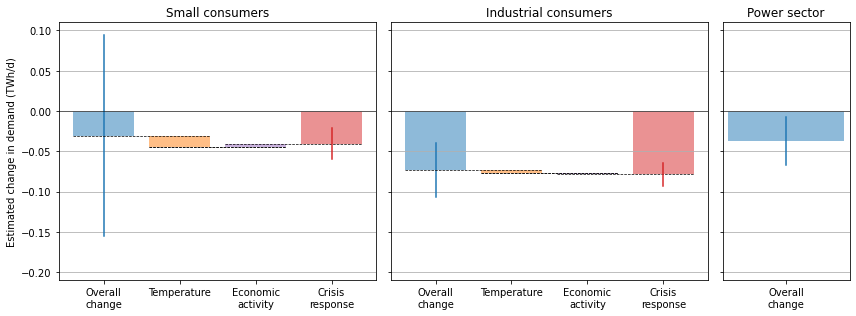

In [30]:
log=False
fitting_start = "2017-01-01"
fitting_end = "2022-05-01"
crisis_start = "2021-09-01" #default: 2021-08-01
results = one_dummy(econ=True)
plt.ylim(-.21, .11)

Fitting period: Quite sensitive to change in fitting period, crisis response of industrial consumers increases with reduced fitting period while small consumers' response is rather stable

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h
slp ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h
industry ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h + manu
power ~ 1 + time + C(month) + C(weekday) + crisis


(-0.21, 0.11)

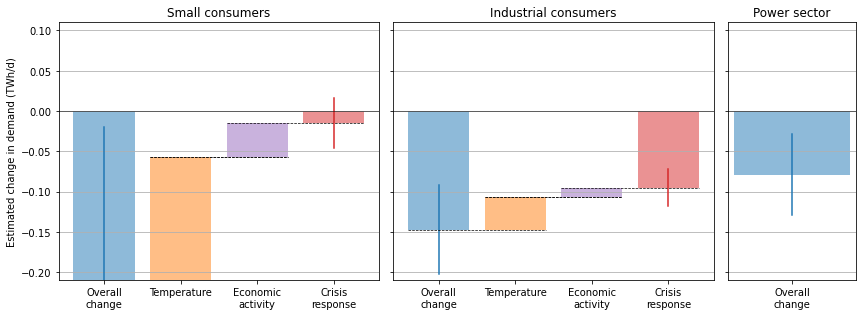

In [31]:
log=False
fitting_start = "2020-01-01" #default: 2017-01-01
fitting_end = "2022-05-01"
crisis_start = "2021-08-01" 
results = one_dummy(econ=True)
plt.ylim(-.21, .11)

Add/remove control variables: Omitting economic activity does not change a lot

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h
power ~ 1 + time + C(month) + C(weekday) + crisis


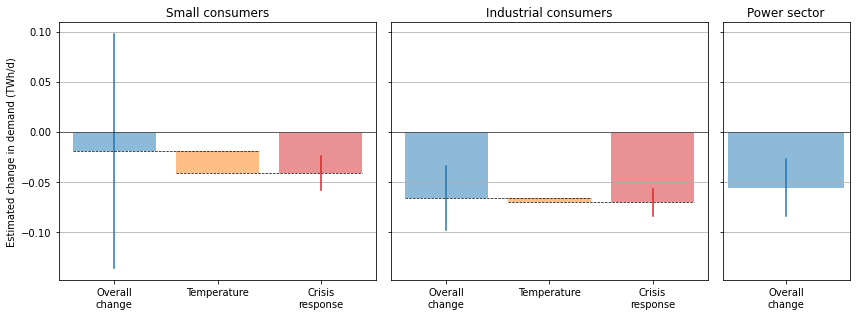

In [32]:
log=False
fitting_start = "2017-01-01"
fitting_end = "2022-05-01"
crisis_start = "2021-08-01"
results = one_dummy(econ=False) #default: econ=True

Fitting period: Fitting only until April 2021 & defining crisis as period between August 2020 and April 2021 shows demand increase for all groups

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h
slp ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h
industry ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h + manu
power ~ 1 + time + C(month) + C(weekday) + crisis


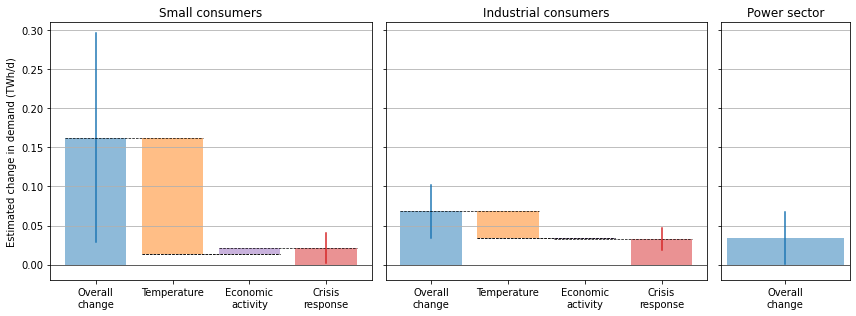

In [33]:
log=False
fitting_start = "2017-01-01"
fitting_end = "2021-05-01" #default: 2022-05-01
crisis_start = "2020-08-01" #default: 2021-08-01
results = one_dummy(econ=True)
plt.ylim(-.02, .31)
plt.savefig(f'one_dummy.png', dpi=300)

#### Monthly dummies

In [34]:
mode = 'monthly'
crisis_start = "2020-05-01"
dummy_list = []
for date in pd.date_range(crisis_start, fitting_end, freq='1m'):
    dummy_name = f'd{date.year}_{date.month}'
    dfx[dummy_name] = dfx.index.map(   
        lambda x: (x.year==date.year) & (x.month==date.month)
    ).values
    dummy_list.append(dummy_name)

slp ~ 1 + time + C(month) + C(weekday) + d2020_5 + d2020_6 + d2020_7 + d2020_8 + d2020_9 + d2020_10 + d2020_11 + d2020_12 + d2021_1 + d2021_2 + d2021_3 + d2021_4
slp ~ 1 + time + C(month) + C(weekday) + d2020_5 + d2020_6 + d2020_7 + d2020_8 + d2020_9 + d2020_10 + d2020_11 + d2020_12 + d2021_1 + d2021_2 + d2021_3 + d2021_4 + w2h + time*w2h
slp ~ 1 + time + C(month) + C(weekday) + d2020_5 + d2020_6 + d2020_7 + d2020_8 + d2020_9 + d2020_10 + d2020_11 + d2020_12 + d2021_1 + d2021_2 + d2021_3 + d2021_4 + w2h + time*w2h + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + d2020_5 + d2020_6 + d2020_7 + d2020_8 + d2020_9 + d2020_10 + d2020_11 + d2020_12 + d2021_1 + d2021_2 + d2021_3 + d2021_4
industry ~ 1 + time + C(month) + C(weekday) + d2020_5 + d2020_6 + d2020_7 + d2020_8 + d2020_9 + d2020_10 + d2020_11 + d2020_12 + d2021_1 + d2021_2 + d2021_3 + d2021_4 + w2h + time*w2h
industry ~ 1 + time + C(month) + C(weekday) + d2020_5 + d2020_6 + d2020_7 + d2020_8 + d2020_9 + d2020_10 + d2020_

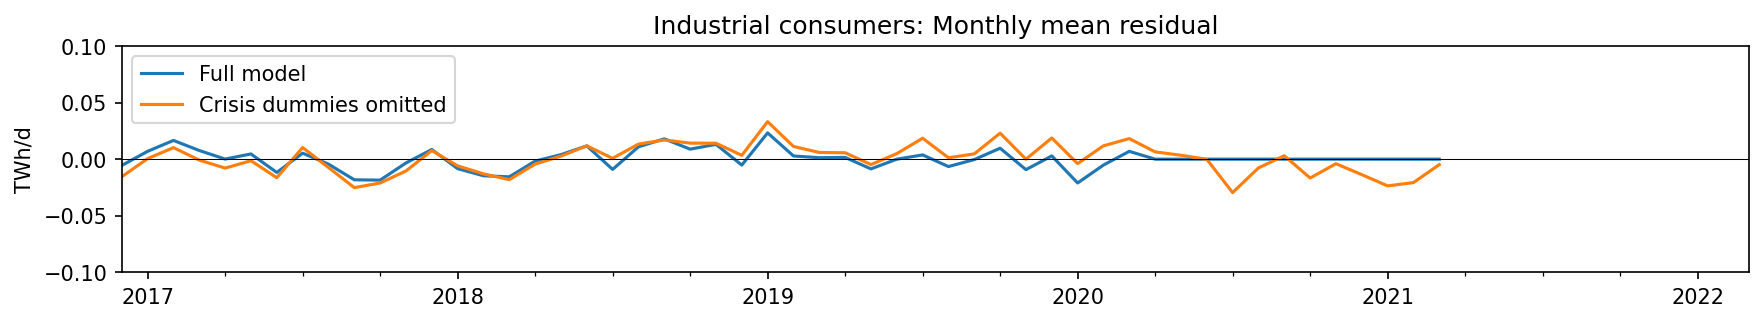

In [35]:
log=False
fitting_start = "2017-01-01"
fitting_end = "2021-05-01"
results = {consumer: all_models(dummy_list, consumer, econ=True) for consumer in ['slp', 'industry', 'power']}

resid_full = results['industry']['temp+econ'].fittedvalues - dfx['industry'] 
resid_fullm = resid_full.resample('1m', label='left').mean()

m_industry = f'industry ~ 1 + time + C(month) + C(weekday) + w2h + time*w2h + manu' # industry: model without crisis dummy 
resid_nodummy = smf.ols(m_industry, dfx[(dfx.index >= fitting_start) & (dfx.index <= fitting_end)]).fit(cov_type='HAC', cov_kwds={'maxlags':6}).fittedvalues - dfx['industry']

resid_nodummym = resid_nodummy.resample('1m', label='left').mean()

plt.figure(figsize=(14, 2), dpi=150)
resid_fullm.plot(label='Full model')
resid_nodummym.plot(label='Crisis dummies omitted')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend(loc='upper left')
plt.title('Industrial consumers: Monthly mean residual')
plt.ylabel('TWh/d')
plt.ylim(-0.1, 0.1)
plt.savefig(f'resid_industry.png', dpi=300)

slp ~ 1 + time + C(month) + C(weekday) + d2020_5 + d2020_6 + d2020_7 + d2020_8 + d2020_9 + d2020_10 + d2020_11 + d2020_12 + d2021_1 + d2021_2 + d2021_3 + d2021_4
slp ~ 1 + time + C(month) + C(weekday) + d2020_5 + d2020_6 + d2020_7 + d2020_8 + d2020_9 + d2020_10 + d2020_11 + d2020_12 + d2021_1 + d2021_2 + d2021_3 + d2021_4 + w2h + time*w2h
slp ~ 1 + time + C(month) + C(weekday) + d2020_5 + d2020_6 + d2020_7 + d2020_8 + d2020_9 + d2020_10 + d2020_11 + d2020_12 + d2021_1 + d2021_2 + d2021_3 + d2021_4 + w2h + time*w2h + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + d2020_5 + d2020_6 + d2020_7 + d2020_8 + d2020_9 + d2020_10 + d2020_11 + d2020_12 + d2021_1 + d2021_2 + d2021_3 + d2021_4
industry ~ 1 + time + C(month) + C(weekday) + d2020_5 + d2020_6 + d2020_7 + d2020_8 + d2020_9 + d2020_10 + d2020_11 + d2020_12 + d2021_1 + d2021_2 + d2021_3 + d2021_4 + w2h + time*w2h
industry ~ 1 + time + C(month) + C(weekday) + d2020_5 + d2020_6 + d2020_7 + d2020_8 + d2020_9 + d2020_10 + d2020_

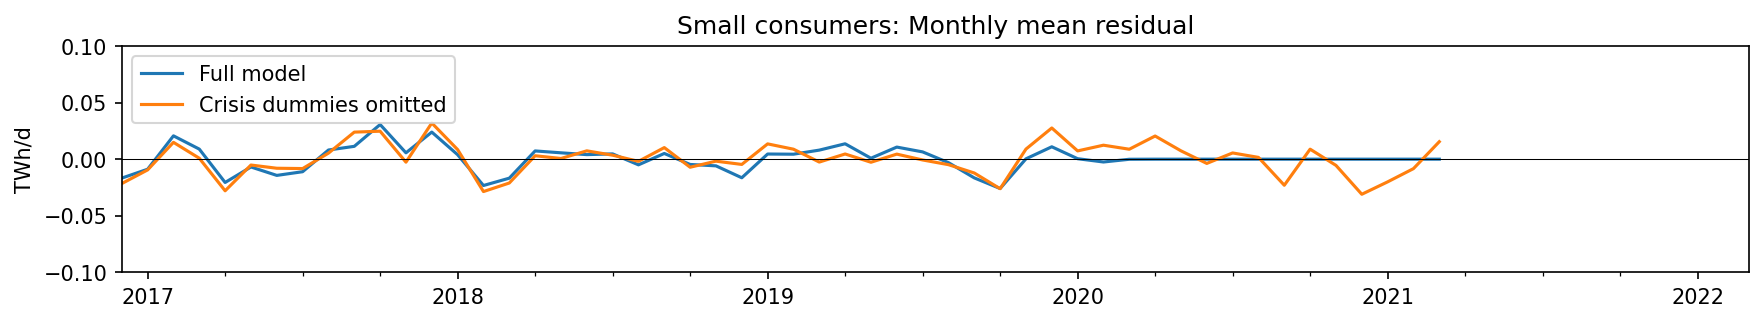

In [36]:
log=False
fitting_start = "2017-01-01"
fitting_end = "2021-05-01"
results = {consumer: all_models(dummy_list, consumer, econ=True) for consumer in ['slp', 'industry', 'power']}

resid_full = results['slp']['temp+econ'].fittedvalues - dfx['slp'] 
resid_fullm = resid_full.resample('1m', label='left').mean()

fitting_start = "2017-01-01"
m_slp = f'slp ~ 1 + time + C(month) + C(weekday) + w2h + time*w2h + hosp + retail' # small consumers: model without crisis dummy 
resid_nodummy = smf.ols(m_slp, dfx[(dfx.index >= fitting_start) & (dfx.index <= fitting_end)]).fit(cov_type='HAC', cov_kwds={'maxlags':6}).fittedvalues - dfx['slp']
resid_nodummym = resid_nodummy.resample('1m', label='left').mean()

plt.figure(figsize=(14, 2), dpi=150)
resid_fullm.plot(label='Full model')
resid_nodummym.plot(label='Crisis dummies omitted')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend(loc='upper left')
plt.title('Small consumers: Monthly mean residual')
plt.ylabel('TWh/d')
plt.ylim(-0.1, 0.1)
plt.savefig(f'resid_small.png', dpi=300)

slp ~ 1 + time + C(month) + C(weekday) + d2020_5 + d2020_6 + d2020_7 + d2020_8 + d2020_9 + d2020_10 + d2020_11 + d2020_12 + d2021_1 + d2021_2 + d2021_3 + d2021_4
slp ~ 1 + time + C(month) + C(weekday) + d2020_5 + d2020_6 + d2020_7 + d2020_8 + d2020_9 + d2020_10 + d2020_11 + d2020_12 + d2021_1 + d2021_2 + d2021_3 + d2021_4 + w2h + time*w2h
slp ~ 1 + time + C(month) + C(weekday) + d2020_5 + d2020_6 + d2020_7 + d2020_8 + d2020_9 + d2020_10 + d2020_11 + d2020_12 + d2021_1 + d2021_2 + d2021_3 + d2021_4 + w2h + time*w2h + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + d2020_5 + d2020_6 + d2020_7 + d2020_8 + d2020_9 + d2020_10 + d2020_11 + d2020_12 + d2021_1 + d2021_2 + d2021_3 + d2021_4
industry ~ 1 + time + C(month) + C(weekday) + d2020_5 + d2020_6 + d2020_7 + d2020_8 + d2020_9 + d2020_10 + d2020_11 + d2020_12 + d2021_1 + d2021_2 + d2021_3 + d2021_4 + w2h + time*w2h
industry ~ 1 + time + C(month) + C(weekday) + d2020_5 + d2020_6 + d2020_7 + d2020_8 + d2020_9 + d2020_10 + d2020_

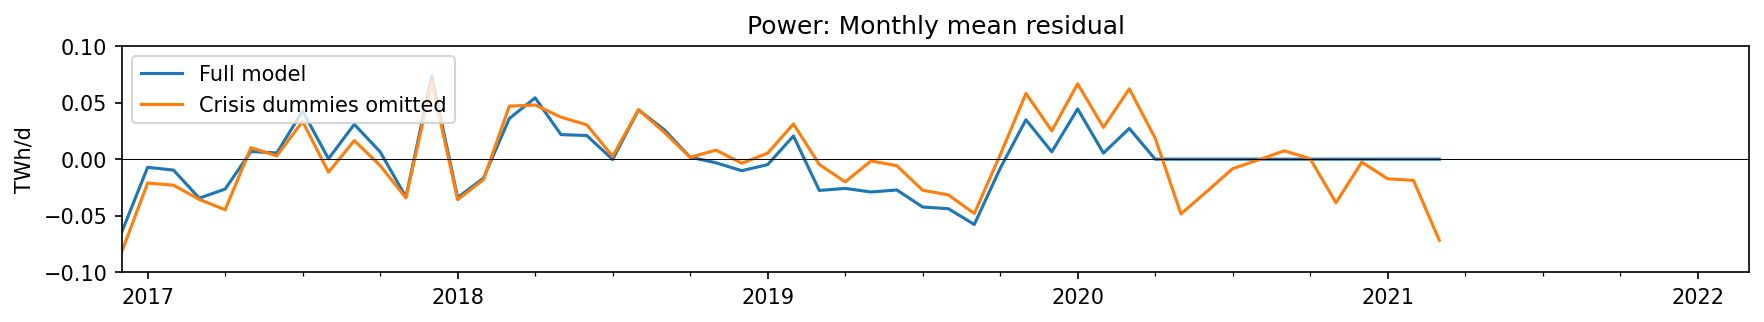

In [37]:
log=False
fitting_start = "2017-01-01"
fitting_end = "2021-05-01"
results = {consumer: all_models(dummy_list, consumer, econ=True) for consumer in ['slp', 'industry', 'power']}

resid_full = results['power']['naive'].fittedvalues - dfx['power'] 
resid_fullm = resid_full.resample('1m', label='left').mean()

fitting_start = "2017-01-01"
m_power = f'power ~ 1 + time + C(month) + C(weekday)' # power: model without crisis dummy 
resid_nodummy = smf.ols(m_power, dfx[(dfx.index >= fitting_start) & (dfx.index <= fitting_end)]).fit(cov_type='HAC', cov_kwds={'maxlags':6}).fittedvalues - dfx['power']
resid_nodummym = resid_nodummy.resample('1m', label='left').mean()

plt.figure(figsize=(14, 2), dpi=150)
resid_fullm.plot(label='Full model')
resid_nodummym.plot(label='Crisis dummies omitted')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend(loc='upper left')
plt.title('Power: Monthly mean residual')
plt.ylabel('TWh/d')
plt.ylim(-0.1, 0.1)
plt.savefig(f'resid_power.png', dpi=300)

In [38]:
dummy_list = []